# LIME (Local Interpretable Model-agnostic Explanations)

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. 

This version of dataset can be found at https://www.kaggle.com/uciml/german-credit

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Read data
app_train = pd.read_csv("data/credits.csv")
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocess and balancing data

I will not go too much into preprocessing, but it is quite important to mention that the original data was highly imbalanced, so I needed discard lots of data to restore balance.

In [8]:
# Iterate through the columns to encode features
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            le = LabelEncoder()
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
# Split data
X = app_train.drop(["TARGET"], axis=1)
y = app_train["TARGET"].to_numpy()
# one-hot encoding of categorical variables
X = pd.get_dummies(X)

features = X.columns

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Transform  training data
X = imputer.fit_transform(X)
X = scaler.fit_transform(X)

# Balancing data
X_0 = X[y == 0]
X_1 = X[y == 1]
y_0 = y[y == 0]
y_1 = y[y == 1]
X_0 = X_0[0:X_1.shape[0], :]
y_0 = y_0[0:X_1.shape[0]]
X = np.vstack([X_0, X_1])
y = np.hstack([y_0, y_1])

# Train test split data and convert to pytorch's tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Size of training data: {X_train.shape}. Testing data {X_test.shape}")

Size of training data: (39720, 242). Testing data (9930, 242)


# Cross validation with 10 splits

Cross Validation is a very useful technique for assessing the effectiveness of your model, particularly in cases where you need to mitigate overfitting. I would recommend this technique unless you are training a neural network.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validation(X, y):
    '''
    K-Folds Cross-Validation
    '''
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    results = []
    for train_index, test_index in kf.split(X):
        classifier = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
        _X_train, _X_test = X[train_index], X[test_index]
        _y_train, _y_test = y[train_index], y[test_index]
        classifier.fit(_X_train, _y_train)
        y_hat = classifier.predict(_X_test)
        results.append(accuracy_score(_y_test, y_hat))
        
    return np.mean(results), np.std(results)

results = cross_validation(X_train, y_train)
print(f"Cross validation on training with Accuracy of {results[0]} ± {results[1]}")

Cross validation on training with Accuracy of 0.9556898288016115 ± 0.00329029390789618


# Train the RBF on the whole training dataset

For LIME to work, we need a pair of complex and simple model. First of all we need to train the complex model.

The final result looks quite good, a bit of performance optimization could yield even better accuracy, but state of the art result is not our target, right now.

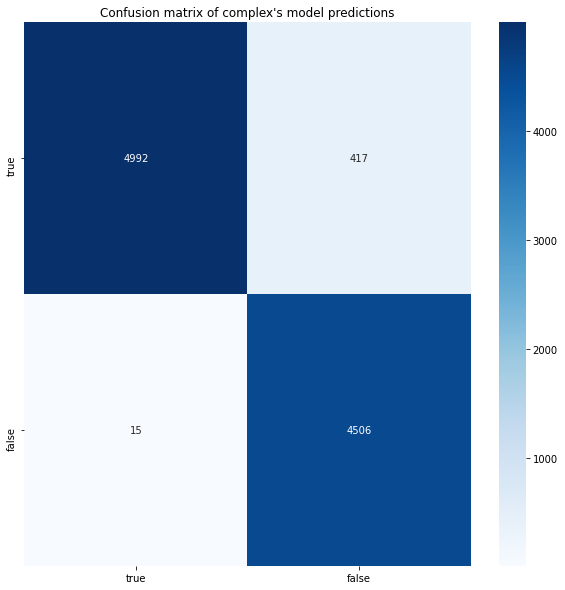

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Train complex model on whole dataset
classifier = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
classifier.fit(X_train, y_train)

# Validate result
validation = confusion_matrix(classifier.predict(X_test), y_test)
df_cm = pd.DataFrame(validation, index = ["true", "false"],
                  columns = ["true", "false"])

plt.figure(figsize=(10, 10))
plt.title("Confusion matrix of complex's model predictions")
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g') 
plt.show()

# Examine the model with LIME

Our model works well, but which feature does it actually use for its decision? What is important and what not? Let us find out

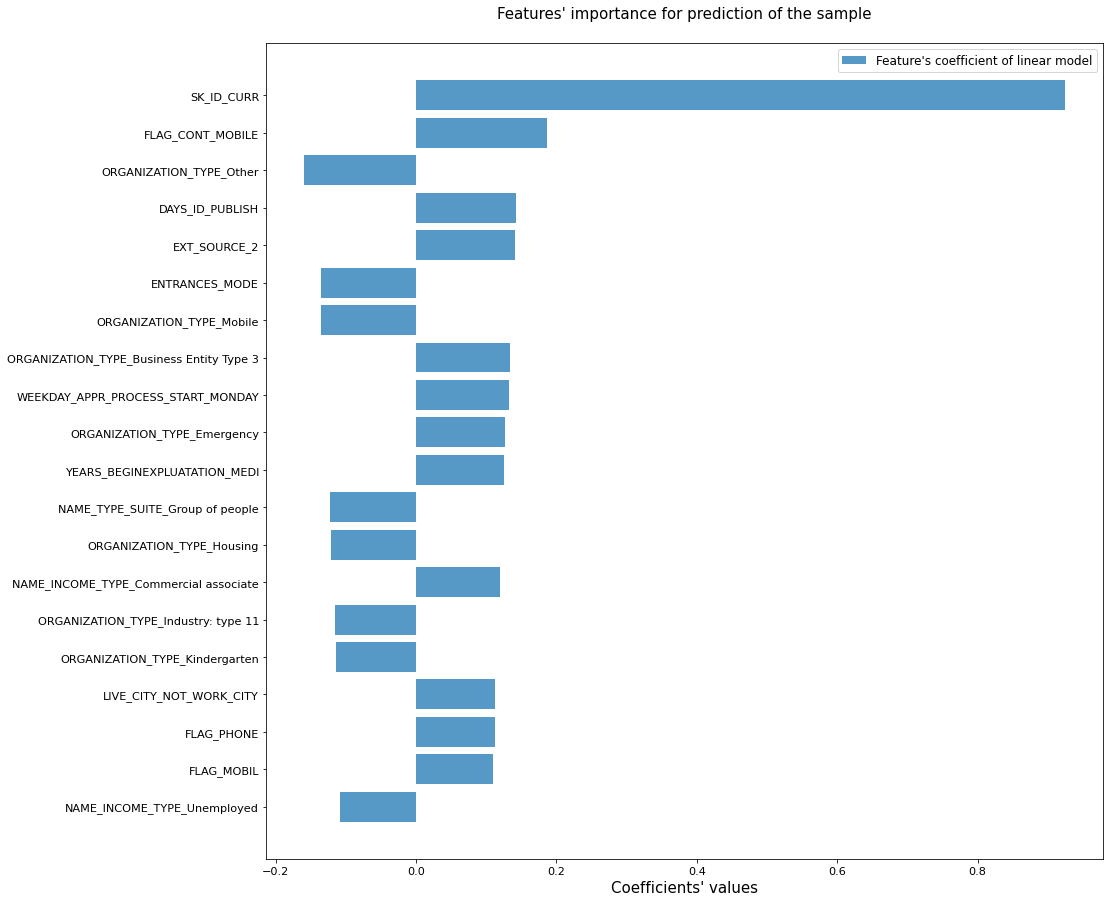

In [12]:
from sklearn.linear_model import LogisticRegression 

# Graphic's parameters
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def lime(x, f, N, variance):
    """
    Lime
    x: sample which we want to examine locally
    f: complex model, could be any,
    N: how many samples do we wish to examine around the original
    variance: how much variability do we want around the original
    
    returns parameters of the simple model
    """
    
    covariance_matrix = np.identity(x.shape[0]) * variance
    # take sample from multivariate gauss 
    
    x_equiv = np.random.multivariate_normal(mean=x, cov=covariance_matrix, size=N)
    
    # Predict sample with the complex model
    y_hat = f.predict(x_equiv).astype(np.float64).reshape(x_equiv.shape[0])
    
    # Fit simple model with input x and prediction y_hat of complex model
    model = LogisticRegression(solver='saga', fit_intercept=False, random_state=42, max_iter=1000)
    model.fit(x_equiv, y_hat)
    
    # Return simple's model parameters
    return list(zip(list(model.coef_[0, :]), list(features)))

# Pick a sample from test dataset
sample = X_test[1, :]

# Let lime examine how our complex model worked on this sample
linear_model = lime(sample, classifier, 1000, 10)
linear_model = sorted(linear_model, key=lambda item: np.abs(item[0]), reverse=True)[:20]
coefs = [feature[0] for feature in linear_model][::-1]
names = [feature[1] for feature in linear_model][::-1]

# Graphic plots
plt.figure(figsize=(15, 15))
plt.title("Features' importance for prediction of the sample")
plt.barh(names, coefs, label="Feature's coefficient of linear model", alpha=0.75)
plt.xlabel("Coefficients' values")
plt.legend()
plt.rcParams['axes.facecolor'] = 'red'
plt.rcParams['savefig.facecolor'] = 'white'
plt.savefig("output.png")
plt.show()

# Verify LIME's output with ONOVA

Just to be sure

In [78]:
from scipy import stats 
models = []

for i in range(0, 100):
    linear_model = lime(sample, classifier, 1000, 10)
    coefs = [feature[0] for feature in linear_model]
    models.append(coefs)
    
stats.f_oneway(*models)

F_onewayResult(statistic=0.42977049702267733, pvalue=0.9999998728951593)

# Interpreting LIME's output

The variable `SK_ID_CURR` plays a great role for the decision of our RBF. The newer the customer, the less chance his/her application will get approved.

`FLAG_OWN_CAR` and `OWN_CAR_AGE` give away how important your car is for your credit institute, basicly you should own a car, but it should not be too old.

We now try to remove `SK_ID_CURR` and see how the model performs. As the graphics below show, the performance of the model dropped significantly.

Conclusion: This very complex model depends too much on a single variable and could as well replaced by a much simpler model. 

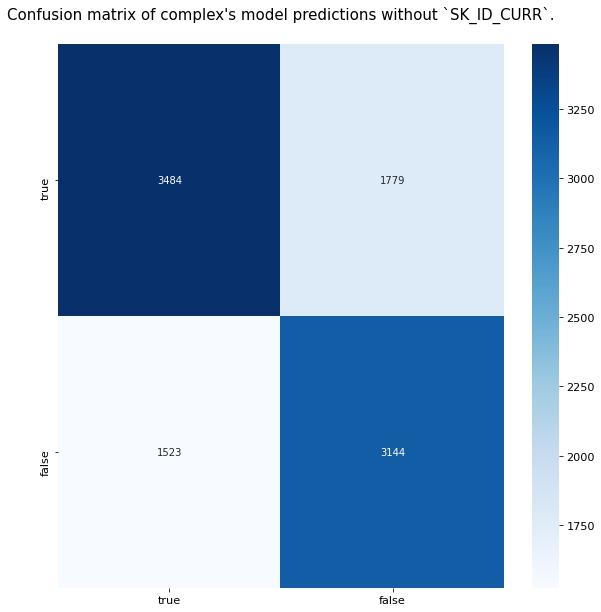

In [17]:
# Set every ID to zero
X_train[:, 0] = 0

classifier = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
classifier.fit(X_train, y_train)


validation = confusion_matrix(classifier.predict(X_test), y_test)
df_cm = pd.DataFrame(validation, index = ["true", "false"],
                  columns = ["true", "false"])

plt.figure(figsize=(10, 10))
plt.title("Confusion matrix of complex's model predictions without `SK_ID_CURR`.")
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g') 
plt.show()